In [11]:
# Importing libraries #
import re, string
import nltk
import numpy as np
import pandas as pd
import lightgbm as lgb
import seaborn as sn
import language_tool_python
import matplotlib.pyplot as plt
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from textacy import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline

tool = language_tool_python.LanguageTool('es-US')
stemmer = SnowballStemmer('spanish')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dmurcia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
# Deifining key functions #

# Preprocessing paragraphs #

def process_paragraph(paragraph):
    """
    This function removes non representative string characters
    input: paragraph extracted from plain text file
    output: paragraph withoput stopwords and punctuation
    """

    # Function for data cleaning #
    def text_cleaning(text_to_clean):
        """
        This function cleans the text data
         """
        text_to_clean = preprocessing.remove.punctuation(text_to_clean)
        text_to_clean = preprocessing.remove.accents(text_to_clean)
        text_to_clean = preprocessing.normalize.whitespace(text_to_clean)
        text_to_clean = preprocessing.normalize.unicode(text_to_clean)
        return text_to_clean
    
    # Function for removing stopwords #
    def stopword(string):
        a = [i for i in string.split() if i not in stopwords.words('spanish')]
        return ' '.join(a)

    # Stemming the paragraph #
    def stemming(text_to_process):
        return ' '.join([ stemmer.stem(i) for i in text_to_process.split() ])

    # Correcting the input pragraph #
    new_paragraph =  stemming(stopword(text_cleaning(tool.correct(paragraph))))

    return new_paragraph

# Testing of functions #
test_paragraph = 'imienlo de dichas areas y la financiacion de los csquemas de pago por servicios ambientales _ lo anterior significa que el hecho que el predio que se restituye el reposo} cumo lo informo corpouraba, se localiza en la ronda hidrica del rio lcon. adcmas que el area que estc ocupa esta establecido como limite dc los humcdales del rio leon y quc segun el pot del municipio dc chigorodo define el area que ocupa este terreno como de preservacion y prolcccion amb'
print(process_paragraph(test_paragraph))

imitenl dich are financiacion esquem pag servici ambiental anterior signif hech predi restitu repos inform corporal localiz rond hidric rio adem are ocup establec limit dc humedal rio leon segun municipi dc vigor defin are ocup terren preservacion produccion acb


In [13]:
# Working with the data of decision #
df_decision = pd.read_csv("/Users/dmurcia/Documents/personal/DS4A/Proyecto final/DS4A/Backend/resources/list decision.csv")
df_decision["Sentencia_cleaned"] = df_decision["Sentencia"].apply(lambda x: process_paragraph(x))
df_decision.head()

,Sentencia,label,Sentencia_cleaned
0,imienlo de dichas areas y la financiacion de l...,1,imitenl dich are financiacion esquem pag servi...
1,abrir un nuevo folio de matricula inmobiliaria...,0,abrir nuev foli matricul inmobiliari vei j dej...
2,al predio restituido se debera brindar segurid...,0,al predi restitu deber brind segur presenci pe...
3,mobiliaria: la esterlina (008-11695): las dali...,0,mobiliari esterlin 008 11695 dali 2 008 11172 ...
4,folio 15 reverso; cuaderno no. 001_ tribunal s...,0,foli 15 revers cuadern 001 tribunal superior d...


In [14]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), use_idf=True, max_features=300)


In [15]:
# Modeling #

# Splitting train data and test data 0.4 #
X_train, X_test, y_train, y_test = train_test_split(df_decision['Sentencia_cleaned'].astype(str), df_decision['label'], test_size=0.4, shuffle=True, random_state=42)

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), use_idf=True, max_features=300)

X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Para prediccion #
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [16]:
# Creating the model #
model = lgb.LGBMClassifier(max_bin=3,
                        max_depth=5,
                        lambda_l2=15,
                        num_leaves=6,
                        min_child_samples=10,
                        subsample=0.3,
                        colsample_bytree=0.5,
                        reg_alpha=1,
                        reg_lambda=10)

# Fitting the model to the tfidf vectors #
model.fit(X_train_vectors_tfidf, y_train)

# Estimating model accuracy #
y_pred = model.predict(X_test_vectors_tfidf)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

y_pred_train = model.predict(X_train_vectors_tfidf)
print("Training Accuracy:", metrics.accuracy_score(y_train, y_pred_train))

[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=10 will be ignored. Current value: lambda_l2=15
Accuracy: 0.8391959798994975
Training Accuracy: 0.8747203579418344


/Users/dmurcia/Documents/personal/DS4A/Proyecto final/DS4A/Backend/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


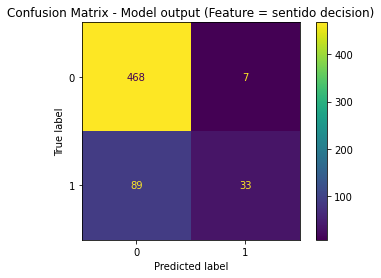

In [17]:
# Grafica de una matriz de confusion #
metrics.plot_confusion_matrix(model, X_test_vectors_tfidf, y_test)
plt.title('Confusion Matrix - Model output (Feature = sentido decision)')
plt.show()

In [21]:
import pickle
path_model ="/Users/dmurcia/Documents/personal/DS4A/Proyecto final/DS4A/Backend/outputs/models/"
path_transformer = "/Users/dmurcia/Documents/personal/DS4A/Proyecto final/DS4A/Backend/outputs/transformers/"
filename_model = "fitted_model_decision.pkl"
filename_transformer = "transformer_model_decision.pkl"
pickle.dump(model,open(path_model+filename_model,'wb'))
pickle.dump(tfidf_vectorizer,open(path_transformer+filename_transformer,'wb'))


In [18]:
# Testing another df similar to train set #
test_df = pd.read_csv("resources/list_to_test.csv")
# Preprocessing of text column #
test_input = test_df["Sentencia"].apply(lambda x: process_paragraph(x))
# Vecotrizing column text using tfidf #
test_input = tfidf_vectorizer.fit_transform(test_input)

# usar predict proba # .targe value_counts() 0 y 1 - Output is a ndarray, [p0, p1] with the probability of each label
test_pred = model.predict_proba(test_input)
print(test_pred)

FileNotFoundError: [Errno 2] No such file or directory: 'resources/list_to_test.csv'

In [ ]:
print(type(test_pred), np.shape(test_pred))

<class 'numpy.ndarray'> (511, 2)


In [ ]:
# Function for reuturning info about model output#
"""
The function takes the vector or array of probabilities output of the model
finds the index of top 5 probabilities of label1 ocurring and prints its 
probability alongside the text of said index.
Input: (vector, text)
Output: (proba) a ndarray of (5,2) containing the top 5 probabilities and [the probaility , text with said probability]

"""
def find_top5(vector):
    ind = np.argpartition(vector[:,1], -4)[-4:]
    proba = vector[:,1][ind]
    return  proba

def print_values(proba):
    for i in proba:
        print('Probability =',proba[i])

In [ ]:
# Retrieving the top 5 higher probabilities #

#Retrieving the index in the vector 2nd column (positive value)
ind = np.argpartition(test_pred[:,1], -6)[-6:]
print('Index for top 5:',ind)

# Retrieving the value of the index found earlier #
probability = test_pred[:,1][ind]
print('Probability for top 5:', probability)

Index for top 5: [247 243 266 254 261 265]
Probability for top 5: [0.48028561 0.62052826 0.54807249 0.57581812 0.58860914 0.61026377]


In [ ]:
## TODO ##
# Queda por implementar una matriz de confusion para validar el rendimiento # Check
# Mirar como usar el modelo de forma facil para implementarlo en backend # Pending con la funcion find_top5 y print_values

# Si se retorna un 0 en el array de vectores se confirma que se puede extraer el feature.#
#Configurar el retorno de la funcion #

# Funcionamiento del modelo #
# Parrafo -> predict clase -> predict proba para sacar vector de proba -> mostrar el top 5 de los parrafos.

# Mas tuning del modelo #
# iperparameter tuning #

# (1) xgboost xgboost is_unbalanced = True. (1) #
# (2) igbm desbalanceado y tecnicas de balance (2) tecnica smout, f1, precision (2) #

# Entrada ideal al modelo (dataframe) #
# indice | Texto sin preprocesar en la vecindad de la palabra | Texo preprocesado | 